# Getting Started with ModelingToolkit.jl

This is an introductory tutorial for ModelingToolkit (MTK). We will demonstrate the basics of the package by demonstrating how to define and simulate simple Ordinary Differential Equation (ODE) systems.

### Your very first ODE

Let's start with a minimal example. The system to be modelled is a first-order lag ("FOL") element:

$$ \dot{x} = \frac{f(t)-x(t)}{\tau} $$

Here, $t$ is the independet variable (time), $x(t)$ is the (scalar) unknown variable, $f(t)$ is an external forcing function, and $\tau$ is a parameter. In MTK, this system can be modelled as follows. For simplicity, we first set the forcing function to a time-independent value of $1$. And the independent variable $t$ is automatically added by `@mtkmodel`.

In [1]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D

In [2]:
@mtkmodel FOL begin
    @parameters begin
        τ = 3.0             # parameters and their values
    end
    @variables begin
        x(t) = 0.0          # dependent variables and their initial conditions
    end
    @equations begin
        D(x) ~ (1 - x) / τ
    end
end

@mtkbuild fol = FOL()

Model fol:
Equations (1):
  1 standard: see equations(fol)
Unknowns (1): see unknowns(fol)
  x(t) [defaults to 0.0]
Parameters (1): see parameters(fol)
  τ [defaults to 3.0]

Note that equations in MTK use the tilde character (~) as equality sign.

`@mtkbuild` creates an instance of `FOL` named as `fol`.

After construction of the ODE, we can solve it using [DifferentialEquations.jl](#https://docs.sciml.ai/DiffEqDocs/stable/):

In [36]:
using DifferentialEquations
using Plots, LaTeXStrings

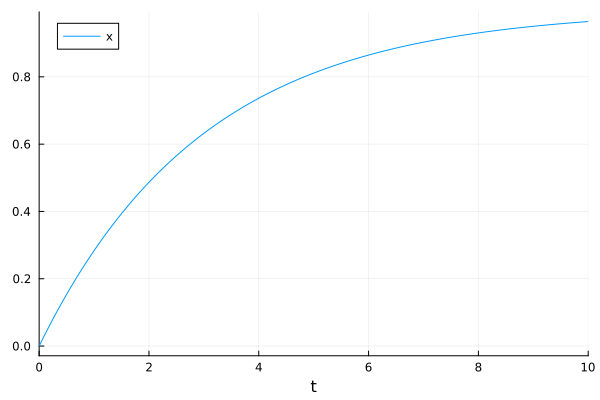

In [4]:
prob = ODEProblem(fol, [], (0.0, 10.0), [])
plot(solve(prob))

If you want to simulate the same model, but with different values for the parameters and initial conditions than the default values, you likely do not want to write an entirely new `@mtkmodel`. ModelingToolkit supports overwriting the default values:

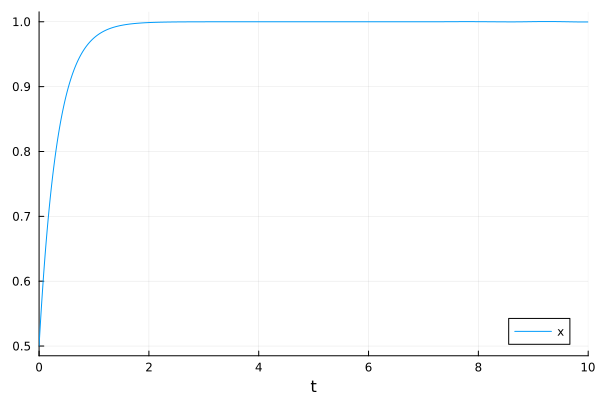

In [5]:
@mtkbuild fol_different_values = FOL(; τ = 1/3, x = 0.5)
prob = ODEProblem(fol_different_values, [], (0.0, 10.0), [])
plot(solve(prob))

In [6]:
# Alternative:
# prob = ODEProblem(fol, [fol.τ => 1/3], (0.0, 10.0), [fol.x => 0.5])

In [7]:
@mtkmodel MyODE begin
    @parameters begin
        k = -0.5
    end
    @variables begin
        x(t) = pi
    end
    @equations begin
        D(x) ~ k*x
    end
end

@mtkbuild myODE = MyODE()

Model myODE:
Equations (1):
  1 standard: see equations(myODE)
Unknowns (1): see unknowns(myODE)
  x(t) [defaults to π]
Parameters (1): see parameters(myODE)
  k [defaults to -0.5]

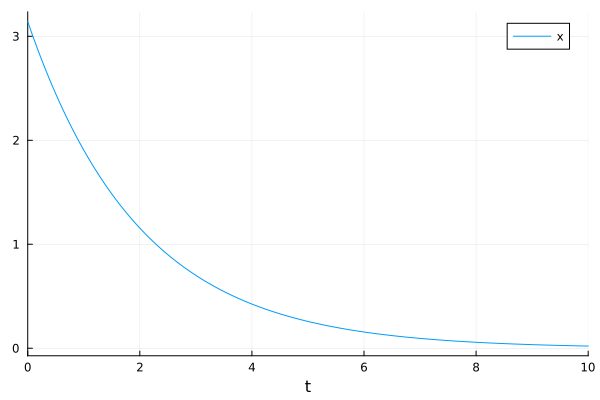

In [8]:
prob = ODEProblem(myODE, [], (0., 10.), [])
sol = solve(prob)
plot(sol)

# Alternative:
# plot(sol[myODE.t], sol[myODE.x])

### Algebraic relations and structural simplification

You could separate the calculation of the right-hand side, by introducing an intermediate variable RHS:

In [9]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D

@mtkmodel FOL begin
    @parameters begin
        τ = 3.0             # parameters and their values
    end
    @variables begin
        x(t) = 0.0          # dependent variables and their initial conditions
        RHS(t)
    end
    @equations begin
        RHS ~ (1 - x) / τ
        D(x) ~ RHS
    end
end

@mtkbuild fol = FOL()

Model fol:
Equations (1):
  1 standard: see equations(fol)
Unknowns (1): see unknowns(fol)
  x(t) [defaults to 0.0]
Parameters (1): see parameters(fol)
  τ [defaults to 3.0]
Observed (1): see observed(fol)

In [10]:
equations(fol)

1-element Vector{Equation}:
 Differential(t)(x(t)) ~ RHS(t)

In [11]:
observed(fol)

1-element Vector{Equation}:
 RHS(t) ~ (1 - x(t)) / τ

MTK still knows how to calculate them out of the information available in a simulation result. The intermediate variable RHS therefore can be plotted along with the unknown variable. Note that this has to be requested explicitly:

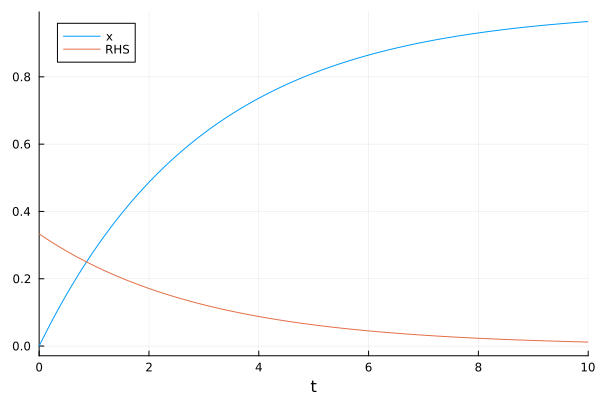

In [12]:
prob = ODEProblem(fol, [], (0.0, 10.0), [])
sol = solve(prob)
plot(sol, idxs = [fol.x, fol.RHS])

### Named indexing of solutions

Note that the indexing of the solution also works via the symbol, and so to get the time series for `x`, you would do:

In [13]:
sol[fol.x]

14-element Vector{Float64}:
 0.0
 3.333277778395056e-5
 0.00036659945265974064
 0.0036931634343634343
 0.03635598665335361
 0.1369848912590037
 0.2861511310403561
 0.4442112892126739
 0.5989648889011088
 0.7323994289466121
 0.8366363855665494
 0.9093330787024341
 0.9548191013493363
 0.9643240555351114

or to get the second value in the time series for `x`:

In [14]:
sol[fol.x, 2]

3.333277778395056e-5

### Specifying a time-variable forcing function

What if the forcing function `f(t)` is not constant? Obviously, one could use an explicit, symbolic function of time:

In [30]:
@mtkmodel FOL begin
    @parameters begin
        τ = 3.0                 # parameters and their values
    end
    @variables begin
        x(t) = 0.0              # dependent variables and their initial conditions
        f(t)
    end
    @equations begin
        f ~ sin(t)
        D(x) ~ (f - x) / τ
    end
end

@mtkbuild fol_variable_f = FOL()

Model fol_variable_f:
Equations (1):
  1 standard: see equations(fol_variable_f)
Unknowns (1): see unknowns(fol_variable_f)
  x(t) [defaults to 0.0]
Parameters (1): see parameters(fol_variable_f)
  τ [defaults to 3.0]
Observed (1): see observed(fol_variable_f)

However, this function might not be available in an explicit form. Instead, the function might be provided as time-series data. MTK handles this situation by allowing us to “register” arbitrary Julia functions, which are excluded from symbolic transformations and thus used as-is. 

For example, you could interpolate given the time-series using [DataInterpolations.jl](#https://github.com/SciML/DataInterpolations.jl). Here, we illustrate this option with a simple lookup ("zero-order hold") of a vector of random values:

In [31]:
value_vector = randn(10)
f_fun(t) = t >= 10 ? value_vector[end] : value_vector[Int(floor(t)) + 1]
@register_symbolic f_fun(t)

@mtkmodel FOLExternalFunction begin
    @parameters begin
        τ = 0.75                    # parameters and their values
    end
    @variables begin
        x(t) = 0.0                  # dependent variables and their initial conditions
        f(t)
    end
    @equations begin
        f ~ f_fun(t)
        D(x) ~ (f - x) / τ
    end
end

@mtkbuild fol_external_f = FOLExternalFunction()

Model fol_external_f:
Equations (1):
  1 standard: see equations(fol_external_f)
Unknowns (1): see unknowns(fol_external_f)
  x(t) [defaults to 0.0]
Parameters (1): see parameters(fol_external_f)
  τ [defaults to 0.75]
Observed (1): see observed(fol_external_f)

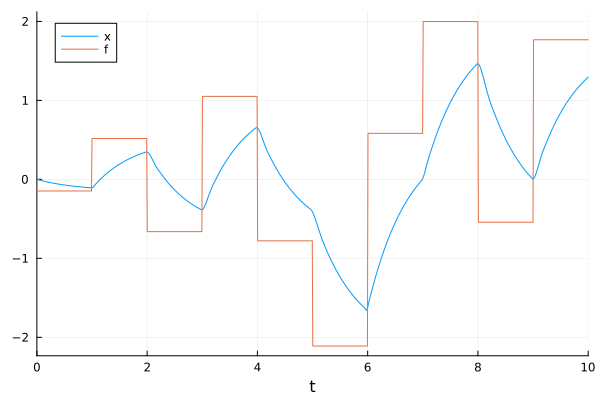

In [32]:
prob = ODEProblem(fol_external_f, [], (0.0, 10.0), [])
sol = solve(prob)
plot(sol, idxs = [fol_external_f.x, fol_external_f.f])

In [39]:
using DataInterpolations
using ModelingToolkitStandardLibrary.Blocks

us = [0.0, 1.5, 0.0]
times = [0.0, 0.5, 1.0]
A = LinearInterpolation(us, times)

@named src = TimeVaryingFunction(A)
vars = @variables x(t) out(t)
eqs = [out ~ src.output.u, D(x) ~ 1 + out]
@named sys = ODESystem(eqs, t, vars, []; systems = [src])

sys = structural_simplify(sys)
prob = ODEProblem(sys, [x => 0.0], (times[1], times[end]))
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 6-element Vector{Float64}:
 0.0
 9.999999999999999e-5
 0.0010999999999999998
 0.011099999999999997
 0.11109999999999996
 1.0
u: 6-element Vector{Vector{Float64}}:
 [0.0]
 [0.000100015]
 [0.001101815]
 [0.011284814999999995]
 [0.12961481499999997]
 [1.7391324646940696]

### Building component-based, hierarchical models

Working with simple one-equation systems is already fun, but composing more complex systems from simple ones is even more fun. The best practice for such a “modeling framework” is to use the `@components` block in the `@mtkmodel` macro:

In [14]:
@mtkmodel FOLUnconnectedFunction begin
    @parameters begin
        τ                       # parameters
    end
    @variables begin
        x(t)                    # dependent variables
        f(t)
        RHS(t)
    end
    @equations begin
        RHS ~ f
        D(x) ~ (RHS - x) / τ
    end
end

@mtkmodel FOLConnected begin
    @components begin
        fol_1 = FOLUnconnectedFunction(; τ = 2.0, x = -0.5)
        fol_2 = FOLUnconnectedFunction(; τ = 4.0, x = 1.0)
    end
    @equations begin
        fol_1.f ~ 1.5
        fol_2.f ~ fol_1.x
    end
end
@mtkbuild connected = FOLConnected()

Model connected:
Equations (2):
  2 standard: see equations(connected)
Unknowns (2): see unknowns(connected)
  fol_1₊x(t) [defaults to -0.5]
  fol_2₊x(t) [defaults to 1.0]
Parameters (2): see parameters(connected)
  fol_1₊τ [defaults to 2.0]
  fol_2₊τ [defaults to 4.0]
Observed (4): see observed(connected)

All equations, variables, and parameters are collected, but the structure of the hierarchical model is still preserved. This means you can still get information about `fol_1` by addressing it by `connected.fol_1`, or its parameter by `connected.fol_1.τ`.

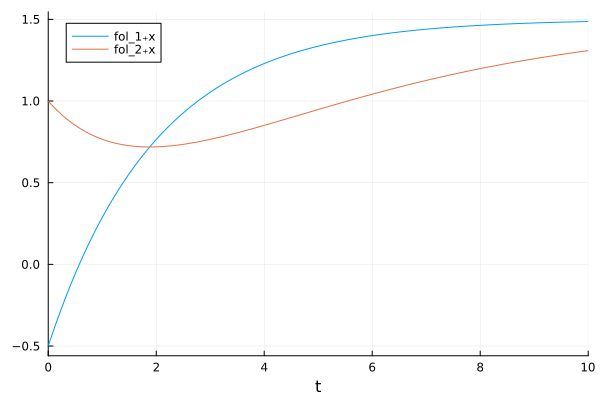

In [15]:
prob = ODEProblem(connected, [], (0.0, 10.0), [])
plot(solve(prob))

### Symbolic and sparse derivatives

One advantage of a symbolic toolkit is that derivatives can be calculated explicitly, and that the incidence matrix of partial derivatives (the “sparsity pattern”) can also be explicitly derived. These two facts lead to a substantial speedup of all model calculations, e.g. when simulating a model over time using an ODE solver.

By default, analytical derivatives and sparse matrices, e.g. for the Jacobian, the matrix of first partial derivatives, are not used. Let's benchmark this (`prob` still is the problem using the connected system above):

In [16]:
using BenchmarkTools
@btime solve(prob, Rodas4());

  39.400 μs (452 allocations: 41.06 KiB)


Now have MTK provide sparse, analytical derivatives to the solver. This has to be specified during the construction of the ODEProblem:

In [17]:
prob_an = ODEProblem(connected, [], (0.0, 10.0), []; jac = true)
@btime solve(prob_an, Rodas4());

  33.200 μs (418 allocations: 39.55 KiB)


In [18]:
prob_sparse = ODEProblem(connected, [], (0.0, 10.0), []; jac = true, sparse = true)
@btime solve(prob_sparse, Rodas4());

  161.300 μs (1653 allocations: 99.46 KiB)


The speedup using the analytical Jacobian is significant. For this small dense model (3 of 4 entries populated), using sparse matrices is counterproductive in terms of required memory allocations. For large, hierarchically built models, which tend to be sparse, speedup and the reduction of memory allocation can also be expected to be substantial. In addition, these problem builders allow for automatic parallelism by exploiting the structural information. For more information, see the [ODESystem](#https://docs.sciml.ai/ModelingToolkit/stable/systems/ODESystem/#ODESystem) page.

## Example: Double Mass-Spring System

In [18]:
@mtkmodel DMSS begin
    @parameters begin
        m1 = 1.
        m2 = 1.
        x1_0 = 1.
        x2_0 = 2.
        k1 = 0.1
        k2 = 0.01
    end
    @variables begin
        x1(t) = 1.1
        x2(t) = 2.3
        v1(t) = 0.
        v2(t) = 0.
    end
    @equations begin
        D(x1) ~ v1
        D(x2) ~ v2
        D(v1) ~ 1/m1 * ( -k1 * (x1 - x1_0) + k2 * ( (x2 - x1) - (x2_0 - x1_0) ) )
        D(v2) ~ 1/m2 * ( -k2 * ( (x2 - x1) - (x2_0 - x1_0) ) )
    end
end

@mtkbuild dmss = DMSS()

Model dmss:
Equations (4):
  4 standard: see equations(dmss)
Unknowns (4): see unknowns(dmss)
  x1(t) [defaults to 1.1]
  x2(t) [defaults to 2.3]
  v1(t) [defaults to 0.0]
  v2(t) [defaults to 0.0]
Parameters (6): see parameters(dmss)
  m2 [defaults to 1.0]
  m1 [defaults to 1.0]
  k2 [defaults to 0.01]
  k1 [defaults to 0.1]
  ⋮

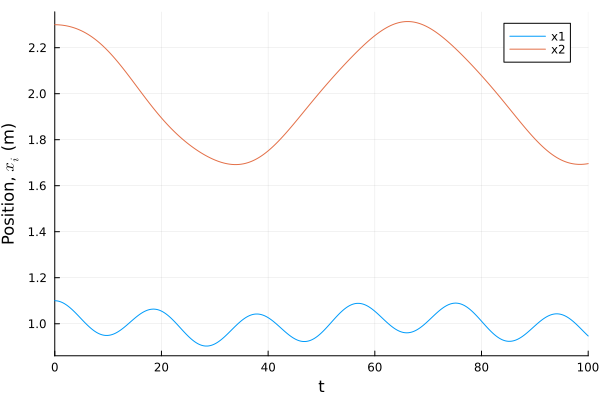

In [ ]:
prob = ODEProblem(dmss, [], (0.0, 100.0), [])
sol = solve(prob);
plot(sol, idxs=(0,1), xlabel=L"Time, $t$ (s)", ylabel=L"Position, $x_i$ (m)")
plot!(sol, idxs=(0,2))